In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

D:\anaconda\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='C:/Users/rohit', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='C:/Users/rohit', train=False, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: C:/Users/rohit
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/rohit
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

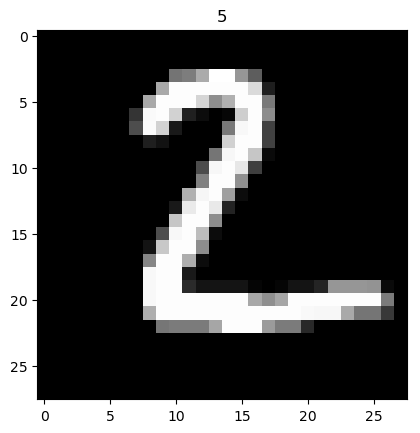

In [7]:
import matplotlib.pyplot as plt
plt.imshow(test_data.data[1], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [8]:
import torch.nn as nn
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 64, 1, 1)
        self.fc1 = nn.Linear(1*1*64, 10)
        

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 1*1*64)
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)

In [9]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [11]:
count_parameters(model)

    54
     6
   864
    16
  4608
    32
  2048
    64
   640
    10
______
  8342


In [12]:
#loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train) 
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 

epoch:  0  batch:  600 [  6000/60000]  loss: 0.08582941  accuracy:  67.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.05471032  accuracy:  78.000%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.32061151  accuracy:  82.600%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.06677695  accuracy:  85.096%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.45676985  accuracy:  86.703%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.18689391  accuracy:  87.894%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.04810549  accuracy:  88.829%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.42940706  accuracy:  89.517%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.01031662  accuracy:  90.135%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00641573  accuracy:  90.625%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.10728665  accuracy:  95.667%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.01710043  accuracy:  95.800%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.16287312  accuracy:  95.844%
epoch:  1  b

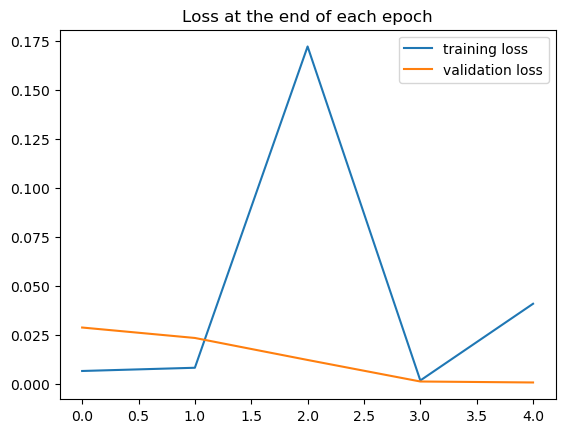

In [14]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [15]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

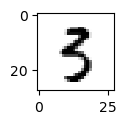

In [16]:
x = 2008
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [17]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 3


In [40]:
import numpy as np
print(type(test_data[x][0]))
tensor = torch.tensor(test_data[x][0])
numpy_array = tensor.numpy()
print("Convert the tensor into numpy array:", numpy_array)

<class 'torch.Tensor'>
Convert the tensor into numpy array: [[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   

D:\anaconda\envs\pytorchenv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
#import cv2
from copy import deepcopy
from random import randint
def GrayScaleConverstion(image: np, greyScalefilter: np =np.array([0.2989, 0.5870, 0.1140])) -> np:
    imagecopy = deepcopy(image)
    greyScaleImage = np.dot(imagecopy[:,:,:3], greyScalefilter)
    return greyScaleImage

def AddSaltPepperNoise(image: np, percent: int) -> np:
    saltPepperImage = np.copy(image)
    saltPepperCount = (((image.shape[0]*image.shape[1])//100)*percent)//2
    for i in range(saltPepperCount):
        saltPepperPixel = [randint(0,image.shape[0])-1, randint(0,image.shape[1] )-1]
        saltPepperImage[saltPepperPixel[0], saltPepperPixel[1]] = 0 
        saltPepperPixel = [randint(0,image.shape[0])-1, randint(0,image.shape[1] )-1]
        saltPepperImage[saltPepperPixel[0], saltPepperPixel[1]] = 255
    return saltPepperImage 

def AddGaussianNoise(image: np,mean: float, std : float):
    noise = np.random.normal(mean, std, size = image.shape)
    noisyImage = image + noise
    return noisyImage 

#tensor = torch.tensor(test_data[x][randint(0, len(test_data[x])])
#numpy_array = tensor.numpy()
#test_image = test_data.data(randint(0, len(test_data.data)))

salt_test_image = AddSaltPepperNoise(GrayScaleConverstion(numpy_array),30)
#gaussain_test_image = AddGaussianNoise(test_image)
#cv2.imshow("salt_test", salt_test_image)
#plt.imshow(salt_test_image)

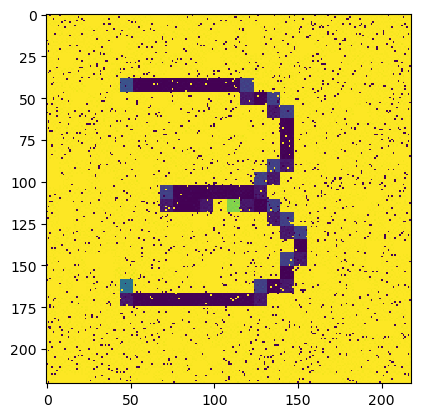

In [19]:

# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
  
# reading the image
testImage = img.imread('op.jpeg')
  
# displaying the image
plt.imshow(testImage)


In [47]:
convert_tensor = transforms.ToTensor()
img1 = convert_tensor(salt_test_image)
tensor = img1.unsqueeze(1)

In [48]:
model.eval()
with torch.no_grad():
    new_pred = model(tensor).argmax()
print("Predicted value:",new_pred.item())

RuntimeError: Calculated padded input size per channel: (1 x 28). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

### The above shows that, to image with noise added to it, the model does not give accurate prediction.